findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


Entropy computed in 0.01552281598560512s
Entropy computed in 0.00015655893366783857s
Entropy computed in 0.00013025198131799698s


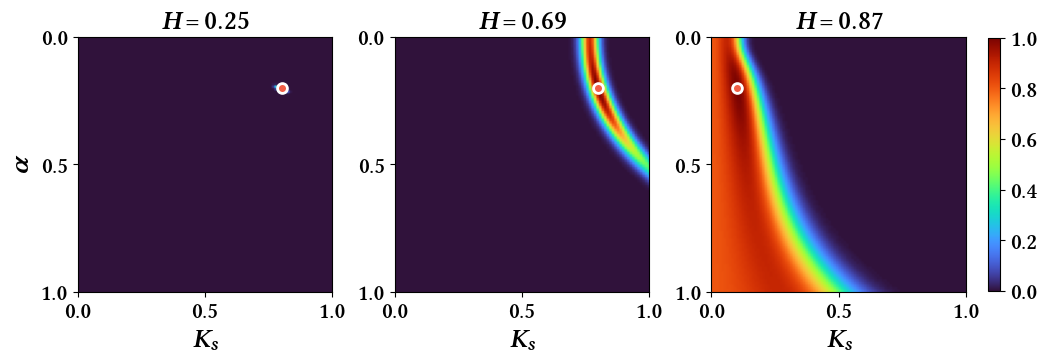

In [1]:
import matplotlib.pyplot as plt
import torch
from math import log, sqrt
from matplotlib.font_manager import fontManager

import time

plt.rcParams["font.family"] = 'Linux Libertine O'
plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = 'custom'
plt.rcParams["mathtext.rm"] = 'Linux Libertine O'
plt.rcParams["mathtext.it"] = 'Linux Libertine O:italic'

red = '#F15E46'
blue = '#3DAEE3'
purple = '#8842eb'
grey = '#BBBBBB'

device = 'cuda'

def plot_pdf(fig, ax, lmax=8, sigma_incoming=0.0, noise_incoming=0.0, alpha_brdf=0.2, specular_brdf=0.8, noise_exitant=0.0):
    # Compute ground-truth values
    l = torch.arange(lmax + 1, device=device)
    incoming_spectrum = (torch.exp(-torch.square(sigma_incoming * l)) + torch.randn(lmax + 1, device=device) * noise_incoming).clamp(1e-5)

    def brdf(incoming_spectrum, l, alpha, specular):
        brdf_spectrum = torch.square(specular * torch.exp(-torch.square(alpha * l)))
        return brdf_spectrum * incoming_spectrum

    def uncertainty(incoming_spectrum, exitant_spectrum, sigma_probability=0.01, grid_resolution=100):
        device = incoming_spectrum.device

        alpha_grid = torch.linspace(0, 1, grid_resolution, device=device)[:, None, None]
        specular_grid = torch.linspace(0, 1, grid_resolution, device=device)[None, :, None]

        l = torch.arange(1, incoming_spectrum.shape[-1], device=device)[None, None]
        brdf_spectrum = torch.square(specular_grid * torch.exp(-torch.square(alpha_grid * l)))
        exitant_spectrum_pred = brdf_spectrum * incoming_spectrum[None, None, 1:]

        loss_grid = torch.mean(torch.square(exitant_spectrum_pred - exitant_spectrum[None, None, 1:]), dim=-1)

        likelihood = torch.exp(-(loss_grid - loss_grid.min()) / (sigma_probability * sigma_probability))
        p = likelihood / likelihood.sum()

        entropy = -(p * torch.log(p.clip(1e-12))).sum() / log(grid_resolution ** 2)
        return entropy, likelihood

    exitant_spectrum = brdf(incoming_spectrum, l, alpha_brdf, specular_brdf)

    # Simulate measurement noise
    exitant_spectrum_noise = (exitant_spectrum + torch.randn(lmax + 1, device=device) * noise_exitant).clamp(1e-5)

    # Compute uncertainty
    start_t = time.perf_counter()
    entropy, likelihood = uncertainty(incoming_spectrum, exitant_spectrum_noise, grid_resolution=100)
    entropy_t = time.perf_counter() - start_t
    print(f'Entropy computed in {entropy_t}s')


    pcm = ax.imshow(likelihood.cpu(), extent=(0, 1, 1, 0), cmap='turbo', vmin=0, vmax=1)
    ax.scatter(specular_brdf, alpha_brdf, marker='o', s=50, c=red, edgecolors='white', linewidths=2, label='GT value')
    ax.set_xticks([0, 0.5, 1.0])
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_xlabel(r'$K_s$', fontsize='large')
    ax.set_title(r'$H={:.2f}$'.format(entropy))
    return pcm


fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].set_ylabel(r'$\alpha$', fontsize='large')
plot_pdf(fig, ax[0], alpha_brdf=0.2, specular_brdf=0.8)
plot_pdf(fig, ax[1], sigma_incoming=0.8, alpha_brdf=0.2, specular_brdf=0.8)
pcm = plot_pdf(fig, ax[2], alpha_brdf=0.2, specular_brdf=0.1)
fig.tight_layout()
fig.colorbar(pcm, ax=ax, shrink=0.85, pad=0.02)
plt.show()